###  Import libraries


In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Hiperparámetros

In [2]:
csv_path          = "jena_climate_2009_2016.csv"
predicted_feature = 'T (degC)'
dropped_features  = ['Tpot (K)', 'p (mbar)','wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'Day cos', 'Year sin']


train_perc = .7
val_perc   = .2

sequence_length = 48
offset          = 5
sampling_rate   = 3
batch_size      = 256

learning_rate   = 0.001
epochs          = 10
loss            = "mse"

### Read CSV

In [3]:
data = pd.read_csv(csv_path, parse_dates=True, index_col=0)

## Correlación de los datos

In [4]:
data.corr()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
p (mbar),1.000000,-0.045375,-0.124718,-0.066755,-0.018352,-0.031546,-0.054370,-0.003401,-0.069762,-0.069804,0.307640,-0.005701,-0.007760,-0.063258
T (degC),-0.045375,1.000000,0.996827,0.895708,-0.572416,0.951113,0.867673,0.761744,0.866755,0.867177,-0.963410,-0.004689,-0.002871,0.038732
Tpot (K),-0.124718,0.996827,1.000000,0.894911,-0.567127,0.947293,0.866205,0.756962,0.866533,0.866955,-0.981345,-0.004195,-0.002224,0.043599
Tdew (degC),-0.066755,0.895708,0.894911,1.000000,-0.156615,0.799271,0.968344,0.435752,0.967599,0.968044,-0.885232,-0.008718,-0.009091,0.049877
rh (%),-0.018352,-0.572416,-0.567127,-0.156615,1.000000,-0.615842,-0.151494,-0.843835,-0.150841,-0.150969,0.514282,-0.005020,-0.009921,-0.015912
VPmax (mbar),-0.031546,0.951113,0.947293,0.799271,-0.615842,1.000000,0.824865,0.875588,0.824460,0.824493,-0.901536,-0.004018,-0.002213,-0.009583
VPact (mbar),-0.054370,0.867673,0.866205,0.968344,-0.151494,0.824865,1.000000,0.449154,0.999851,0.999856,-0.850241,-0.009600,-0.010316,0.018418
VPdef (mbar),-0.003401,0.761744,0.756962,0.435752,-0.843835,0.875588,0.449154,1.000000,0.448641,0.448689,-0.698290,0.001852,0.005317,-0.030881
sh (g/kg),-0.069762,0.866755,0.866533,0.967599,-0.150841,0.824460,0.999851,0.448641,1.000000,0.999997,-0.853325,-0.009479,-0.010163,0.019376
H2OC (mmol/mol),-0.069804,0.867177,0.866955,0.968044,-0.150969,0.824493,0.999856,0.448689,0.999997,1.000000,-0.853769,-0.009477,-0.010158,0.019607


### Convertimos estampillas de tiempo todo a segundos

In [5]:
timestamp_s = data.index
timestamp_s = timestamp_s.map(pd.Timestamp.timestamp)

day = 24*60*60
year = 365.2425 * day

data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

## Dropeamos las características que no tienen correlación

In [6]:
df = data.drop(dropped_features, axis = 1)

predicted_feature = df.columns.get_loc(predicted_feature)

### Normalización de los datos

In [7]:
df_length = len(df)

train_length = int(df_length*train_perc)
val_length   = int(df_length*(train_perc+val_perc))

train_mean = df.values[:train_length].mean(axis=0)
train_std  = df.values[:train_length].std(axis=0)

df_norm = (df.values - train_mean) / train_std
df_norm = pd.DataFrame(df_norm)

### Dividimos los datos


In [8]:
train_df = df_norm[:train_length-1]
val_df   = df_norm[train_length:val_length-1]
test_df_norm  = df_norm[val_length:]
#test_df       = df[val_length:]

###  Create datasets


In [9]:
start = sequence_length*sampling_rate + offset*sampling_rate
end   = train_length + start

x_train = train_df
y_train = df_norm[[predicted_feature]][start:end]

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train.values,
    y_train,
    sequence_length = sequence_length,
    sampling_rate = sampling_rate,
    shuffle=True,
    batch_size = batch_size
)

In [10]:
start = train_length + sequence_length*sampling_rate + offset*sampling_rate
end   = val_length + start

x_val = val_df
y_val = df_norm[[predicted_feature]][start:end]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val.values,
    y_val,
    sequence_length = sequence_length,
    sampling_rate = sampling_rate,
    shuffle=False,
    batch_size = batch_size
)

In [11]:
start = val_length + sequence_length*sampling_rate + offset*sampling_rate
x_end = len(test_df_norm) - sequence_length*sampling_rate - offset*sampling_rate

x_test = test_df_norm[:x_end]
y_test = df_norm[[predicted_feature]][start:]

dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test.values,
    y_test,
    sequence_length = sequence_length,
    sequence_stride = sampling_rate,
    sampling_rate = sampling_rate,
    shuffle=False,
    batch_size = batch_size
)

### Creamos el modelo


In [12]:
for batch in dataset_train.take(1):
    x, y = batch
    
input_shape = x.shape[1], x.shape[2]

In [13]:
inputs = keras.layers.Input(input_shape)
lstm_layer = keras.layers.LSTM(32, return_sequences=True)(inputs)
lstm_layer2 = keras.layers.LSTM(32)(lstm_layer)
output = keras.layers.Dense(1)(lstm_layer2)

model = keras.Model(inputs, output)
model.compile(keras.optimizers.Adam(learning_rate), loss)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 11)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 48, 32)            5632      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,985
Trainable params: 13,985
Non-trainable params: 0
_________________________________________________________________


### Entrenamos el modelo

In [14]:
path_checkpoint = "model_test.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(dataset_train, epochs = epochs, validation_data=dataset_val, callbacks = [es_callback, modelckpt_callback])

Epoch 1/10
1150/1150 [==============================] - 100s 82ms/step - loss: 0.0438 - val_loss: 0.0273

Epoch 00001: val_loss improved from inf to 0.02726, saving model to model_test.h5
Epoch 2/10
1150/1150 [==============================] - 98s 85ms/step - loss: 0.0246 - val_loss: 0.0243

Epoch 00002: val_loss improved from 0.02726 to 0.02430, saving model to model_test.h5
Epoch 3/10
1150/1150 [==============================] - 98s 85ms/step - loss: 0.0232 - val_loss: 0.0242

Epoch 00003: val_loss improved from 0.02430 to 0.02416, saving model to model_test.h5
Epoch 4/10
1150/1150 [==============================] - 103s 90ms/step - loss: 0.0226 - val_loss: 0.0238

Epoch 00004: val_loss improved from 0.02416 to 0.02384, saving model to model_test.h5
Epoch 5/10
1150/1150 [==============================] - 101s 87ms/step - loss: 0.0220 - val_loss: 0.0238

Epoch 00005: val_loss improved from 0.02384 to 0.02377, saving model to model_test.h5
Epoch 6/10
1150/1150 [========================

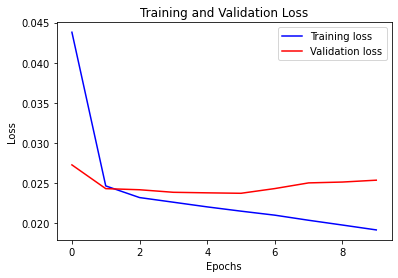

In [15]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

### Mostramos los resultados

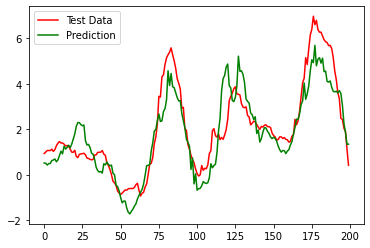

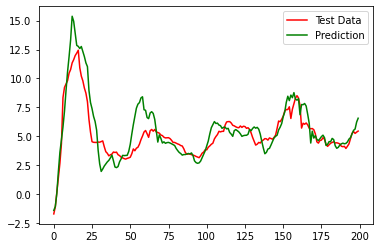

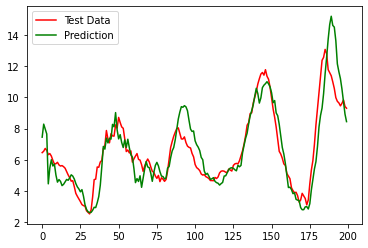

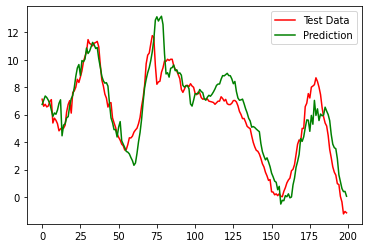

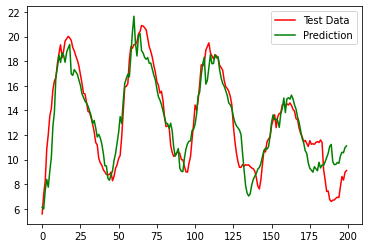

In [16]:
for batch in dataset_test.take(5):
    x, y = batch
    y_pred = model.predict(x)

    y_pred = y_pred * train_std[predicted_feature] + train_mean[predicted_feature]
    y = y * train_std[predicted_feature] + train_mean[predicted_feature]
    
    fig, ax = plt.subplots()
    
    ax.plot(y[0:200], c='r', label="Test Data")
    ax.plot(y_pred[0:200],c='g', label="Prediction")
    plt.legend()
    plt.show()

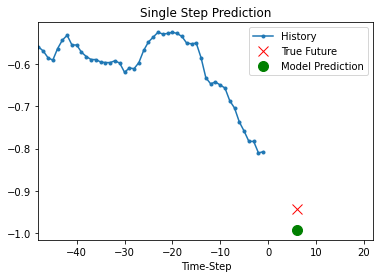

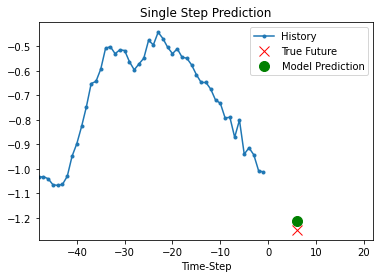

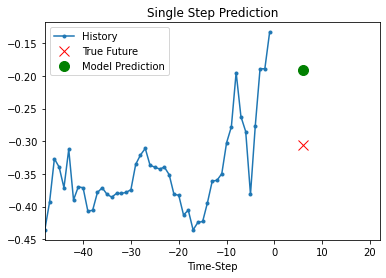

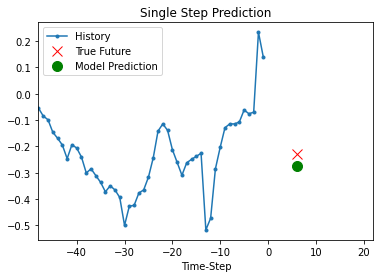

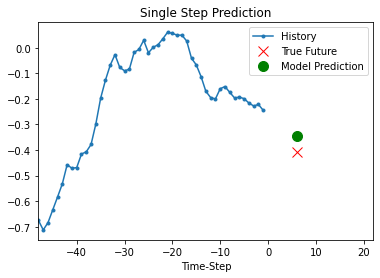

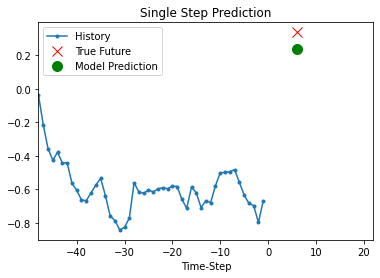

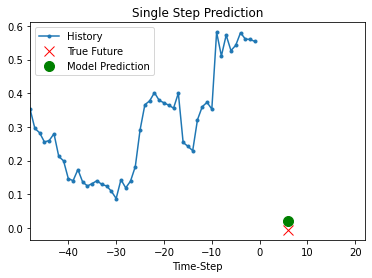

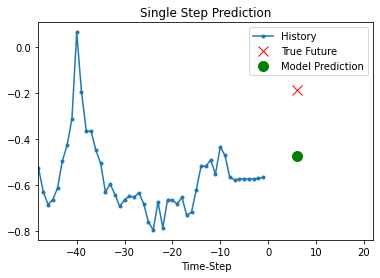

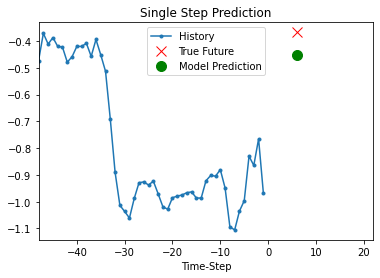

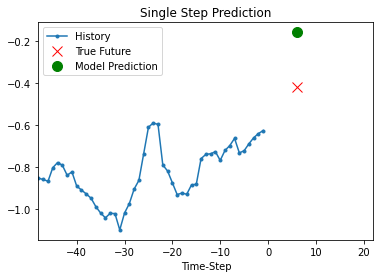

In [22]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x1, y1 in dataset_test.take(10):
    show_plot(
        [x1[0][:, 1].numpy(), y1[0].numpy(), model.predict(x1)[0]],
        6,
        "Single Step Prediction",
    )

In [18]:
#Pruebo a partir de 24 datos como predice
for batch in dataset_test.take(1):
    x, y = batch
    set_prediction = x[10:11]    
    y_realPrediction = y[10]

y_individualPredic = model.predict(set_prediction)
print(set_prediction)

tf.Tensor(
[[[-0.83630766 -0.58207691  0.90570986 -0.82730259 -0.71436809
   -0.6972557  -0.73488377 -0.73370019  1.20817615  0.59777242
    1.26082176]
  [-0.84439619 -0.58924766  0.91174957 -0.83120238 -0.71912014
   -0.69933238 -0.73862691 -0.73839443  1.21305935  0.75996172
    1.26105833]
  [-0.85248472 -0.58924766  0.9359084  -0.8364021  -0.71912014
   -0.7055624  -0.73862691 -0.73839443  1.21745423  0.90914923
    1.26129474]
  [-0.85941775 -0.59498426  0.94798782 -0.84030189 -0.72387219
   -0.70971574 -0.74237005 -0.74308867  1.22306991  1.04278232
    1.26153099]
  [-0.86172876 -0.59641841  0.94798782 -0.84030189 -0.72387219
   -0.70971574 -0.74611318 -0.74543579  1.22062831  1.15857449
    1.26176708]
  [-0.86519527 -0.59641841  0.96006724 -0.84290175 -0.72624822
   -0.71386909 -0.74611318 -0.74543579  1.22941807  1.25454449
    1.26200301]
  [-0.85941775 -0.59211596  0.95402753 -0.84030189 -0.72149617
   -0.71179242 -0.74237005 -0.74074155  1.22795311  1.32905026
    1.26223

In [19]:

print(y_individualPredic * train_std[predicted_feature] + train_mean[predicted_feature]) 


[[0.85803986]]


In [20]:
print(y_realPrediction * train_std[predicted_feature] + train_mean[predicted_feature])

tf.Tensor([1.46], shape=(1,), dtype=float64)
